<a href="https://colab.research.google.com/github/Zeroflip64/sub/blob/main/%D0%9C%D0%B0%D1%81%D1%82%D0%B5%D1%80%D1%81%D0%BA%D0%B0%D1%8F_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Библиотеки

In [1]:
!pip install nltk
!pip install textstat
!pip install pysrt
!pip install catboost
!pip install tensorflow_text


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Скрипт который переводит все файлы в нужный формат


In [3]:
import os
import chardet

folder_path = "/content/drive/MyDrive/учеба/Новая папка/a c/a c"


for filename in os.listdir(folder_path):
   
    if filename.endswith(".srt"):
        
        with open(os.path.join(folder_path, filename), "rb") as f:
            byte_sequence = f.read()

        
        encoding = chardet.detect(byte_sequence)['encoding']

        
        if encoding and encoding.lower() != 'utf-8':
            with open(os.path.join(folder_path, filename), "w", encoding="utf-8") as f:
                f.write(byte_sequence.decode(encoding))

In [9]:
import pandas as pd
import numpy as np
import nltk

nltk.download('stopwords')
nltk.download('punkt')
import spacy
import pysrt
import datetime
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from textstat import textstat
import re
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler,RobustScaler
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import f1_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Данные и предварительная обработка

In [5]:
df=pd.read_excel('/content/drive/MyDrive/учеба/мастерская 2/movies_labels.xlsx')
nlp = spacy.load("en_core_web_sm")

In [6]:
empty=['The Secret Life of Pets.en','Up (2009)','Terminator_2_Judgment_Day_1991_roNy',
       'Glass Onion','Matilda(2022)','Bullet train','Thor: love and thunder','Lightyear',
       'The Grinch','Jumanji (1995)','Cars(2006).TLF.en','Ratatouille(2007).part1.en','Frozen.2013','.DS_Store']
for i in empty:
  df=df.loc[df['Movie'] != i]

df=df.set_index(df['Movie'])

df[[['avg_sent_length','avg_word_length','lexical_diversity','flesch_kincaid','gunning','smog','time','difficult_words']]]=None

df=df.drop(['Movie','id'],axis=1)


### Заметка
Написал дополнительный класс который создает дополнительные фичи,я звял длину предложения ,длину слова,словестное разнообразие,время субтитра,соотношение сложных слов,а так же использовал три лексических еста которые определяют урвоень сложности текста.


In [7]:
class features:
  def __init__(self,first):
    
    self.first=first
    self.sentences = sent_tokenize(first.text)
    words = word_tokenize(first.text)
    self.words = [word.lower() for word in words if word.isalpha()]

  def avg_sent_length(self):# длина предложения
    mean=[]
    mean.append(np.mean([len(i) for i in self.sentences]))
    return np.mean(mean) 

  def avg_word_length(self):# длина слова
    return np.mean([len(word) for word in self.words])

  def lexical_diversity(self):#словестное разнообразие
    doc = nlp(self.first.text)
    num_subordinate_clauses = sum([1 for token in doc if token.dep_ in ('acl', 'advcl', 'csubj', 'ccomp', 'xcomp')])
    syntactic_complexity = num_subordinate_clauses / len(self.sentences)
    return syntactic_complexity

  def flesch_kincaid(self):# тесты 
    return textstat.flesch_kincaid_grade(self.first.text)

  def gunning(self):
    return textstat.gunning_fog(self.first.text)

  def smog(self):
    return textstat.smog_index(self.first.text)

  def time(self):#среднее время разговора
    seconds=[]
    for i in self.first:
      start_time = datetime.datetime.combine(datetime.date.today(), i.start.to_time())
      end_time = datetime.datetime.combine(datetime.date.today(), i.end.to_time())
      seconds.append((end_time-start_time).total_seconds())
    return np.mean(seconds)

  def difficult_words(self):# отношение  сложных слов
        non_stopwords = [word for word in self.words if word not in stopwords.words('english')]
        return len(non_stopwords) / len(self.words)


  

In [10]:
try:
  for j in df.index.unique():
    subs = pysrt.open(f'/content/drive/MyDrive/учеба/мастерская 2/Subtitles_all/Новая папка/{j}.srt')
    x=features(subs)
    
    df.loc[j,['subs','avg_sent_length','avg_word_length','lexical_diversity','flesch_kincaid','gunning','smog','time','difficult_words']]=subs.text,x.avg_sent_length(),x.avg_word_length(),x.lexical_diversity(),x.flesch_kincaid(),x.gunning(),x.smog(),x.time(),x.difficult_words()
except ZeroDivisionError:
    print(j)

In [11]:
df=df.reset_index()


In [12]:
df[[i for i in df.columns[2:-1]]]=df[[i for i in df.columns[2:-1]]].astype(float)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Movie              232 non-null    object 
 1   Level              232 non-null    object 
 2   avg_sent_length    232 non-null    float64
 3   avg_word_length    232 non-null    float64
 4   lexical_diversity  232 non-null    float64
 5   flesch_kincaid     232 non-null    float64
 6   gunning            232 non-null    float64
 7   smog               232 non-null    float64
 8   time               232 non-null    float64
 9   difficult_words    232 non-null    float64
 10  subs               232 non-null    object 
dtypes: float64(8), object(3)
memory usage: 20.1+ KB


### Обработка фичей

Я решил использовать новые признаки из тестов и через них раделить на группы.Я взял минимальные значения тестов группы выше и если хотя бы в двух тестах этот порог не проходят значит оставляем группу ниже а елси проходит то ставим выше.

In [14]:
counts=df.groupby('Level')['flesch_kincaid','gunning','smog'].min()
print(counts)

for i in [i for i in df['Level'].unique() if len(i)>3]:

  if 'A' in i :
    print(df.loc[df['Level']==i,['flesch_kincaid','gunning','smog']]>counts.loc['B1'])
  else:
    print(df.loc[df['Level']==i,['flesch_kincaid','gunning','smog']]>counts.loc['B2'])
    

            flesch_kincaid  gunning  smog
Level                                    
A2                     1.2     3.24   5.2
A2/A2+                 1.0     2.83   5.5
A2/A2+, B1             2.1     3.43   6.2
B1                     1.0     3.06   5.1
B1, B2                 1.4     3.10   5.8
B2                     1.0     3.04   5.6
C1                     1.2     3.65   5.9
     flesch_kincaid  gunning  smog
4              True     True  True
5              True     True  True
6              True     True  True
7              True     True  True
8              True     True  True
10             True     True  True
19             True     True  True
27             True     True  True
31             True     True  True
34             True    False  True
41            False     True  True
45             True     True  True
48             True     True  True
62             True     True  True
71             True     True  True
73             True     True  True
78             True     Tru

<ipython-input-14-9ff64474778d>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  counts=df.groupby('Level')['flesch_kincaid','gunning','smog'].min()


После проверки я решил все же оставить у уровня А2+ уровень А2 что бы не ыбло сильного дисбаланса в выборке


In [15]:
df['Level']=np.where(df['Level']!='A2/A2+',df['Level'],'A2')
df['Level']=np.where(df['Level']!='A2/A2+, B1',df['Level'],'B1')
df['Level']=np.where(df['Level']!='B1, B2',df['Level'],'B2')

In [16]:
df['Level'].value_counts()

B2    105
B1     57
C1     39
A2     31
Name: Level, dtype: int64

In [17]:
df=df.loc[df['lexical_diversity']<2]

# Разработка модели

Я решил векторизировать целые предложения,и для этого написал небольшую функцию в которой проходит очищение текста и представление в виде вектора для этого я решил использовать модель USE.

In [18]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)


In [56]:
def vectorizer(data):

  subtitles = data.split('\n\n')

  # Define a regular expression pattern to match timestamps, speaker names, and unwanted text
  pattern = re.compile('\d+:\d+:\d+,\d+ --> \d+:\d+:\d+,\d+.*\n|<.*?>|\[.*\]')

  # Process each batch separately
  
  subtitle_sentences = []
  for subtitle in subtitles:
        # Remove unwanted data using the regular expression pattern
        subtitle = re.sub(pattern, '', subtitle)

        # Split the subtitle into lines using newline (\n) as a delimiter
        subtitle_lines = subtitle.split('\n')

        # Tokenize each line into sentences using a sentence tokenizer
        for line in subtitle_lines:
            subtitle_sentences.extend(nltk.sent_tokenize(line))
  subtitle_sentences = [s for s in subtitle_sentences if re.match(r'[A-Z]', s)]
      # Encode the sentences into vectors using the USE model
  subtitle_embeddings = model(subtitle_sentences)

    # Compute the mean pooling over the set of vectors
  summary_vector = np.mean(subtitle_embeddings, axis=0)

  
          

  return summary_vector

In [69]:
X_vecorizer=np.array([vectorizer(i) for i in df['subs']])

### Заметка 
Нам необходимо прейсойденить признаки к вектору субтитров для этого мы мы другие призраки переводит в вектор и пресойденяем.


In [70]:
def column(data):
  return np.array(data).reshape(-1,1)

avg_sent_length=column(df['avg_sent_length'])
avg_word_lengt=column(df['avg_word_length'])
lexical_diversity=column(df['lexical_diversity'])
flesch_kincaid=column(df['flesch_kincaid'])
gunning=column(df['gunning'])
smog=column(df['smog'])
time=column(df['time'])
difficult_words=column(df['difficult_words'])


In [74]:

scaller=StandardScaler()
X_other=np.concatenate([avg_sent_length,avg_word_lengt,lexical_diversity,flesch_kincaid,gunning,smog,time,difficult_words],axis=1)
X_other_scaller=scaller.fit_transform(X_other)
X_concate=np.concatenate([X_other_scaller,X_vecorizer],axis=1)



In [76]:
features=X_concate
label=LabelEncoder()
target=label.fit_transform(df['Level'])

features_train,features_test,target_train,target_test=train_test_split(features,target,test_size=0.25,stratify=target,shuffle=True, random_state=122435)

grid = CatBoostClassifier(
    iterations=1000,  
    learning_rate=0.1,  
    depth=6, 
    l2_leaf_reg=3, 
    loss_function='MultiClass', 
    random_seed=42 ,verbose=False
    
)
features_train,features_test,target_train,target_test=train_test_split(features,target,test_size=0.25,shuffle=target,random_state=122435)
grid.fit(features_train,target_train)

print('Accuracy :',accuracy_score(target_test,grid.predict(features_test)))
print('F1_score:',f1_score(target_test,grid.predict(features_test),average='weighted'))

Accuracy : 0.6545454545454545
F1_score: 0.6533215077605321


### Вываод 
Модель достигла результатов только в 65% точности и F1 так же около 65 % .
Нижне представлены графики с небольшой информацией с статистическими данными о наших субтитрах.


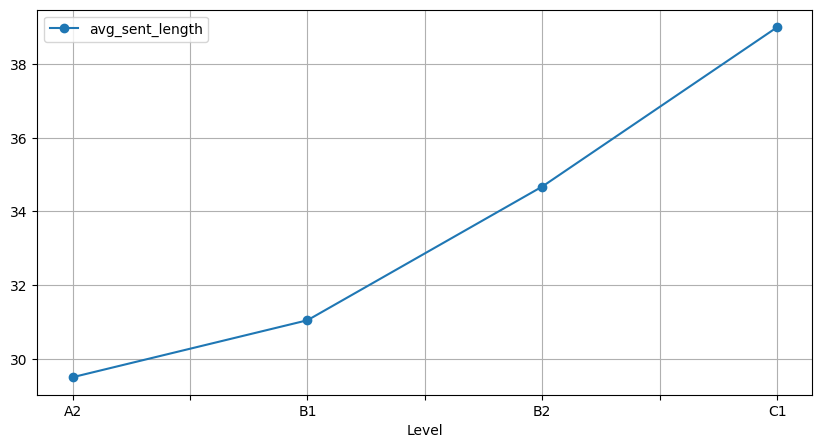

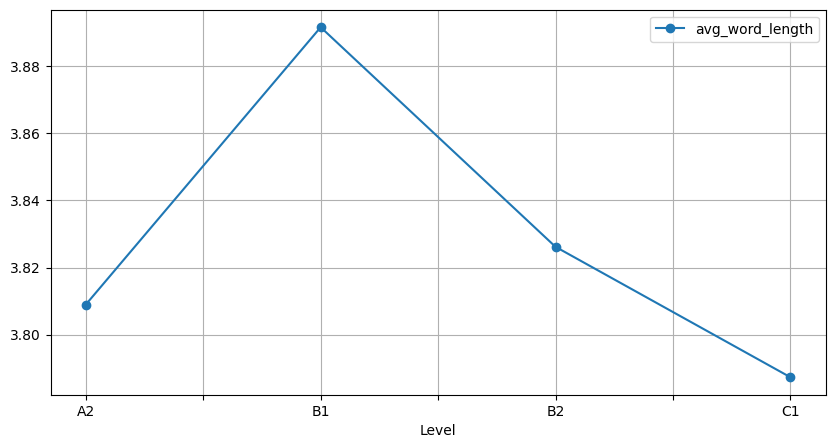

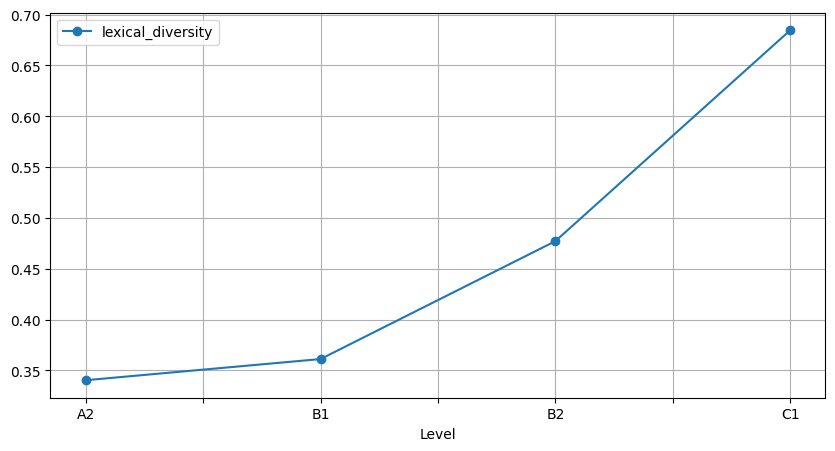

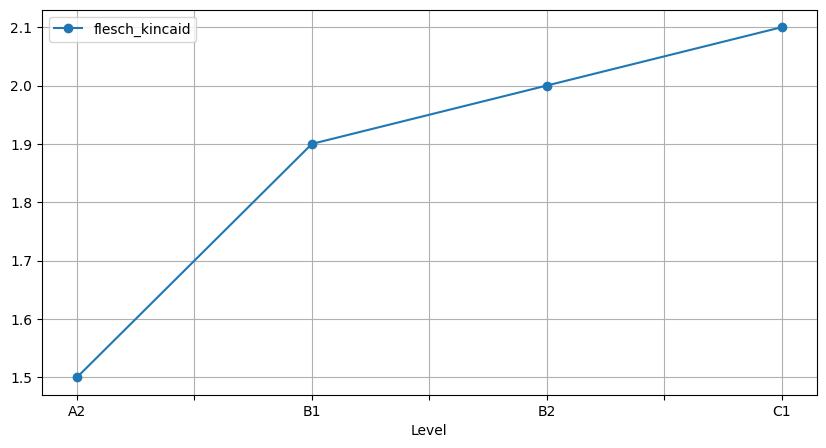

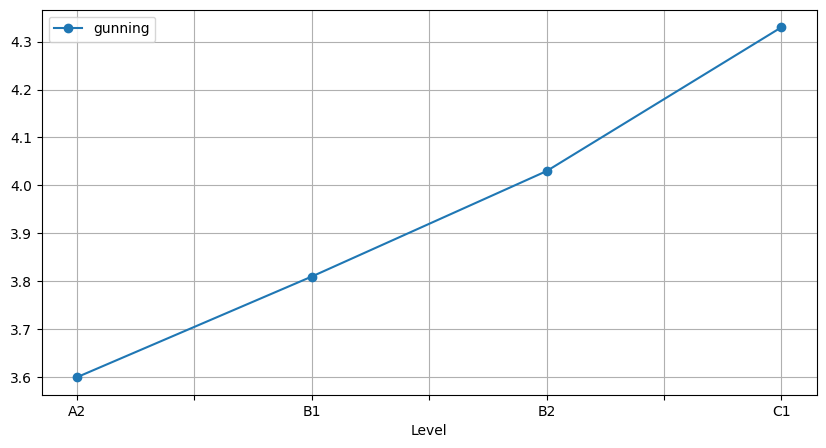

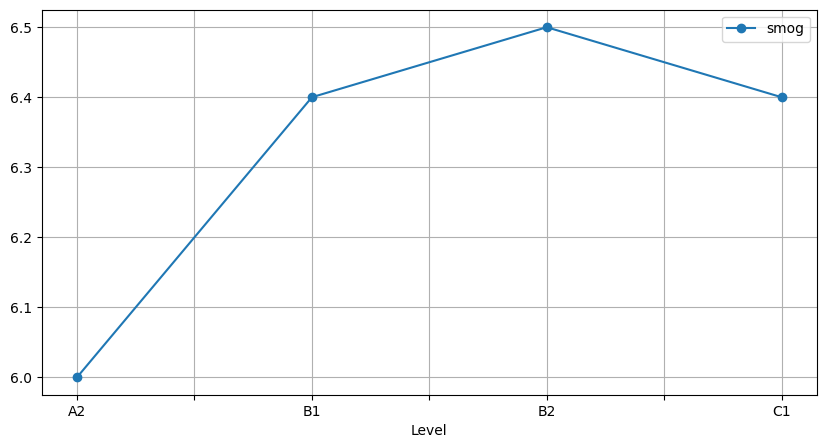

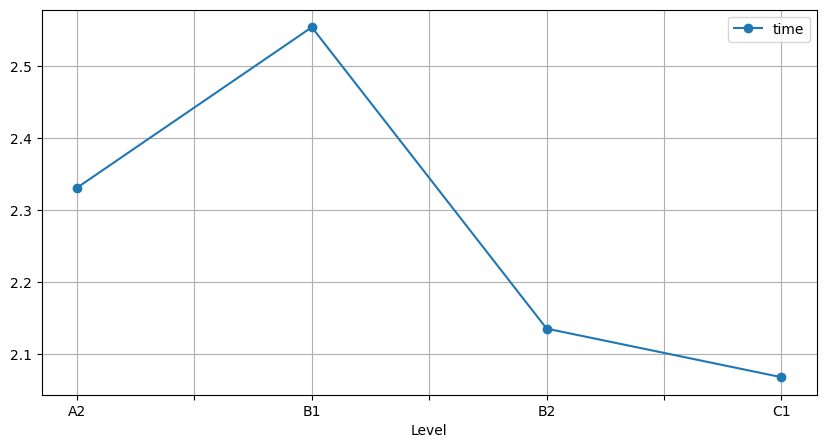

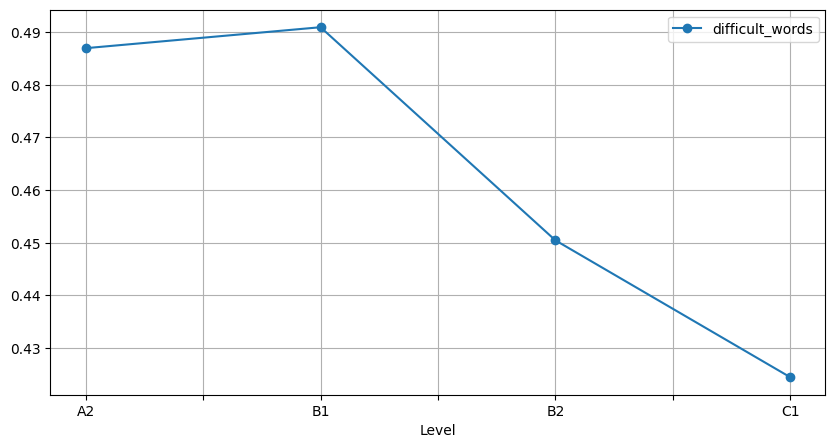

In [77]:
import matplotlib.pyplot as plt

for i in df.columns[2:-1]:
  df.pivot_table(index='Level',values=i,aggfunc='median').plot(figsize=(10,5),grid=True,style='o-')
  plt.show()